# Radial Basis Function Network - Iris

## Packages and Data Set

### Import Packages

In [1]:
# Numeric computing
import numpy as np
import random as rnd
# Importing data sets
from sklearn import datasets
# Splitting data sets randomly into training and test sets
from sklearn.cross_validation import train_test_split
# Graphing and images
import matplotlib.pyplot as plt
%matplotlib inline
# Inputting latex
from IPython.display import display, Math, Latex

### Iris Data Set

In [2]:
iris = datasets.load_iris()
irisInput = iris.data
irisTarget = iris.target
print( "The Iris dataset gives a vector of four dimensions to predict one of three classes")
print( "An example of the iris input is") 
print( irisInput[0:4])
print( irisTarget[0:4])

The Iris dataset gives a vector of four dimensions to predict one of three classes
An example of the iris input is
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]]
[0 0 0 0]


## Defining Functions

### Normalizing Data

In [3]:
# xNorm normalises the data to between -1 and 1
def xNorm(data):
    data_ = np.transpose(data)
    for i in range(len(data_)):
        max_ = max(data_[i]); min_ = min(data_[i])
        if (max_ - min_) == 0:
            data_[i] = -1
        else:
            data_[i] = [2*float(data_[i][j] - min_)/float(max_ - min_) - 1 \
                    for j in range(len(data_[i]))]
    return np.transpose(data_)

# yNorm uses one-to-many normalization to return a n unit vector s.t.
# yNorm(2) -> [0,1,0,0,0,0,0,0,0]
def yNorm(data):
    dataDim = len(data)
    yData = np.zeros((dataDim,max(data)+1))
    for i in range(dataDim):
        yData[i][data[i]-1] = 1
    return yData

### RBF Functions

The two RBF activation functions are


<IPython.core.display.Math object>

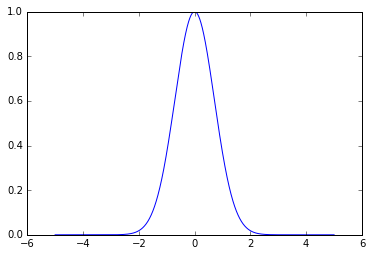

<IPython.core.display.Math object>

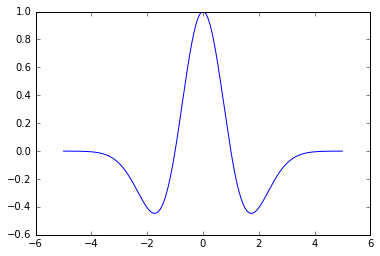

In [4]:
# r calculates the Euclidean Distance between vectors
def r(x,centre):
    if isinstance(x,float):
        return abs(x - centre)
    else:
        return np.sqrt(sum([(x[i]-centre[i])**2 for i in range(len(x))]))

# Scaling Parameter
def sigma(data,centre):
    m = len(data)
    return float(1)/float(m)*sum([r(data[i], centre) for i in range(m)])

# Calculates beta for the required activaion function
def betaCalc(data, centres):
    beta = np.zeros(len(centres))
    for i in range(len(centres)):
        sigma_ = sigma(data, centres[i])
        beta[i] = float(1) / float(2*sigma_**2)
    return beta

# Gaussian activation function
def hGauss(x, centre, beta):
    return np.exp(-beta*r(x,centre)**2)

# Ricker Wavelet activation function
def hRickerWavelet(x, centre, beta):
    return (1 - r(x,centre)**2)*np.exp(-beta*r(x,centre)**2/2)

# Plotting Examples of both activation functions
xExVals = np.linspace(-5,5,1000)
yExGaussVals = [hGauss(x,0,1) for x in xExVals]
yExRWVals = [hRickerWavelet(x, 0, 1) for x in xExVals]
print("The two RBF activation functions are")
display(Math(r'hGauss(r) = e^{-\beta r^2}'))
plt.plot(xExVals, yExGaussVals); plt.show()
display(Math(r'hRickerWavelet(r) = (1-r)e^{\frac{-\beta r^2}{2}}'))
plt.plot(xExVals, yExRWVals); plt.show()

### RBF Network

In [5]:
# Complete RBF Network
def f(x,beta,w,centres, actFunct):
    if actFunct == "RW":
        h = hRickerWavelet
    else:
        h = hGauss
    F = np.zeros(len(w))
    for j in range(len(F)):
        for i in range(len(centres)):
            F[j] += w[j][i]*h(x, centres[i], beta[i])
    return F

# Classification function
# classFunct([1.5 32 5 2 7]) --> [0 1 0 0 0]
def classFunct(F):
    y_ = np.zeros(len(F))
    y_[np.argmax(F)] = 1
    return y_

## K-Means Clustering

### Defining K-Means

In [6]:
# Euclidean Distance Measure
def dist(point1, point2):
    n = 0
    if isinstance(point1, int):
        n = abs(point2 - point1)
    else:
        for i in range(len(point1)): 
            n += abs(point2[i] - point1[i])
    return n

# Randomly assigns the data into n separate clusters at initiation
def initKMeans(data,dim):
    clusters = [[] for _ in range (dim)]
    dataIndex = range(len(data))
    dataIndex = sorted(dataIndex, key=lambda k:rnd.random())
    split = int(round(len(data)/dim)); n = 0
    for i in range(len(clusters)):
        clusters[i] = [data[j] for j in dataIndex[n:n+split]]
        n += split
    dif = len(data) - n
    clusters[-1] += [data[j] for j in dataIndex[-dif:]]
    return clusters

# Updates the centres of the clusters after every iteration
def kMeanCentUpdate(clusters,data):
    centres = [[] for _ in range(len(clusters))]
    for i in range(len(clusters)):
        if isinstance(data[0], int):
            centres[i] =  np.mean(clusters[i])
        elif len(clusters[i]) == 0:
            centres[i] = [[0] for _ in range(len(data[0]))]
        else:
            centres[i] = [[] for _ in range(len(data[0]))]
            for j in range(len(centres[i])):
                targetArray = [clusters[i][x][j] for x in range(len(clusters[i]))]
                centres[i][j] = np.mean(targetArray)
    return centres

# Updates the data, placing each data point in closest nearest cluster
def kMeanUpdate(clusters, centres):
    nClust = [[] for _ in range(len(clusters))]
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            distArray = [dist(clusters[i][j], centres[x]) for x in range(len(centres))]
            optCluster = np.argmin(distArray)
            nClust[optCluster] += [clusters[i][j]]
    return nClust

# Complete K-Means algorithm
def kMeans(data, dim):
    clusters = initKMeans(data,dim) 
    oldCentres = None; centres = 0;
    n = 0
    while centres != oldCentres and n < 20:
        oldCentres = centres
        centres = kMeanCentUpdate(clusters,data) 
        clusters = kMeanUpdate(clusters, centres)
        n += 1
    return clusters, centres

### K-Means Example

Here we will use the iris dataset to give an example of k-Means clustering


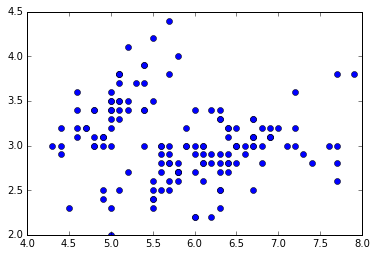

The data split into two clusters


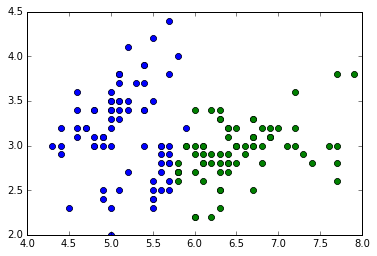

The data split into three clusters


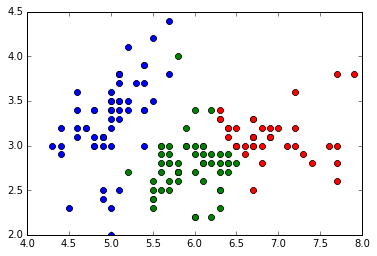

In [7]:
X = [irisInput[i][0] for i in range(len(irisInput))]
Y = [irisInput[i][1] for i in range(len(irisInput))]
print("Here we will use the iris dataset to give an example of k-Means clustering")
plt.plot(X,Y,'o')
plt.show()
trainData = np.column_stack((X,Y))
clusters,_ = kMeans(trainData,2)
x1 = [clusters[0][i][0] for i in range(len(clusters[0]))]
y1 = [clusters[0][i][1] for i in range(len(clusters[0]))]
x2 = [clusters[1][i][0] for i in range(len(clusters[1]))]
y2 = [clusters[1][i][1] for i in range(len(clusters[1]))]
plt.plot(x1,y1,'o')
plt.plot(x2,y2,'o')
print("The data split into two clusters")
plt.show()
clusters,_ = kMeans(trainData,3)
x_1 = [clusters[0][i][0] for i in range(len(clusters[0]))]
y_1 = [clusters[0][i][1] for i in range(len(clusters[0]))]
x_2 = [clusters[1][i][0] for i in range(len(clusters[1]))]
y_2 = [clusters[1][i][1] for i in range(len(clusters[1]))]
x_3 = [clusters[2][i][0] for i in range(len(clusters[2]))]
y_3 = [clusters[2][i][1] for i in range(len(clusters[2]))]
plt.plot(x_1,y_1,'o')
plt.plot(x_2,y_2,'o')
plt.plot(x_3,y_3,'o')
print("The data split into three clusters")
plt.show()

## Network Training

### Loss Functions

In [8]:
print( "The two loss functions we will look at are")
display(Math(r'loss(x) = \frac{1}{m}\Bigg(\sum_{i=1}^{m} \bigg({\begin{cases}{0}& '\
             +r'\text{if }f(x^i) = y^i\\{1} & \text{else}\\\end{cases}}\bigg)\Bigg)'))
display(Math(r'logLoss(x) = \frac{1}{m}(\sum_{i=1}^{m}y^{i}log(f(x^{i})) + ' \
             + '(1-y^{i})log(1-f(x^i))'))

def loss(w, beta, centres, trainData, trainTarget,actFunct):
    cost = 0
    for i in range(len(trainData)):
        cost += sum([abs(classFunct(f(trainData[i], beta, w, centres,actFunct))[j] - \
                         trainTarget[i][j]) for j in range(len(trainTarget[i]))])
    return float(cost)/float(2*len(trainData))

def logLoss(w, beta, centres, trainData, trainTarget,actFunct):
    cost = 0
    for i in range(len(trainData)):
        cost += abs(sum([(trainTarget[i][j]*np.log(f(trainData[i],beta,w,centres,actFunct)\
                                                   [j]) + (1 - trainTarget[i][j])*\
                          np.log(f(trainData[i],beta,w,centres,actFunct)[j])) \
                 for j in range(len(trainTarget[i]))]))
    return float(cost) / float(len(trainData))

The two loss functions we will look at are


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Gradient Descent Function

In [9]:
def gradDescent(weighting, beta, centres, trainData, targetData, learnRate, actFunct):
    if actFunct == "RW":
        h = hRickerWavelet
    else:
        h = hGauss
    wGrad = np.zeros((len(weighting),len(weighting[0])))
    for point in range(len(trainData)):
        F = f(trainData[point],beta,weighting,centres,actFunct)
        Y = targetData[point]
        diff = [tar - pred for pred,tar in zip(F,Y)]
        for i in range(len(wGrad)):
            for j in range(len(wGrad[1])):
                wGrad[i][j] += -h(trainData[point], centres[j], beta[j])*diff[i]
    w_ = np.zeros((len(weighting),len(weighting[1])))
    for i in range(len(weighting)):
        w_[i] = [origW - learnRate*wIter for origW,wIter in zip(weighting[i],wGrad[i])]
    return w_

### Gradient Descent Optimisation Function

In [10]:
def optimise(weighting,beta,centres,trainData,targetData,learnRate,maxIter,minTOL,actFunct):
    n = 0; TOL = 10e10; optTOL = [10e10, None, None]
    h = []
    while n < maxIter: #and TOL > minTOL:
        weighting=gradDescent(weighting,beta,centres,trainData,targetData,\
                              learnRate,actFunct)
        TOL = loss(weighting,beta,centres,trainData,targetData,actFunct)
        n += 1
        h += [[n, TOL]]
        if n%100 == 0:
            print("The TOL at n = " + str(n) + " is " + str(round(TOL,6)))
        if optTOL[0] > TOL:
            optTOL = [TOL, n, weighting]
        if (optTOL[1]+250) < n:
            print("RBF converged to min at iteration n = "+str(optTOL[1])+" with a "\
                  + "TOL of " + str(round(optTOL[0],6)))
            return optTOL[2], h
    return weighting, h

## RBF Network Results

### Classification Percentage Function

In [11]:
# Function measures the accuracy of the RBF Network
def classPercent(weighting,beta,centres,xData,yData,actFunct):
    correct = 0
    M = len(xData)
    for i in range(M):
        y = yData[i]
        y_ = classFunct(f(xData[i],beta,weighting,centres,actFunct))
        if (y_ == y).all():
            correct += 1
    percentage = round((float(correct)/float(M))*100,3)
    print("RBF correctly identified "+str(correct)+" out of "+str(M)+" points")
    print("This gives an accuracy of "+str(percentage)+"% ")

### Complete RBF Net function

In [12]:
def completeRBFNet(trainData, targetData, rbfIndex, learnRate, maxIter):
    # Splits the data into a training and test set
    xTrain, xTest, yTrain, yTest = train_test_split(trainData, targetData, test_size=0.33, \
                                               random_state = 42)
    # Normalize data
    xTrain_ = xNorm(xTrain); xTest_ = xNorm(xTest)
    yTrain_ = yNorm(yTrain); yTest_ = yNorm(yTest)
    # Defining the rbf centres and beta value
    _,centres = kMeans(xTrain_, rbfIndex)
    beta = betaCalc(xTrain_, centres)
    # Defining the initial weighting matrix
    yLength = len(yTrain_[0])
    weighting = np.random.random((yLength, rbfIndex))
    # Optimising the RBF weight matrix
    print("Optimising the RBF weights")
    print("")
    minTOL = 0.01
    print("For the Gaussian activation function")
    optWeightsGauss,optListGauss = optimise(weighting,beta,centres,xTrain_,yTrain_,\
                                           learnRate,maxIter,minTOL,"Gauss")
    print("")
    print("For the Ricker Wavelet activation function")
    optWeightsRW,optListRW = optimise(weighting,beta,centres,xTrain_,yTrain_,\
                                           learnRate,maxIter,minTOL,"RW")
    # Plotting a graph of iterations against TOL value for both Gaussian and Ricker Wavelet
    # activation functions
    optListGaussIndex = range(len(optListGauss)) 
    nValsGauss = [optListGauss[i][0] for i in optListGaussIndex]
    TOLValsGauss = [optListGauss[i][1] for i in optListGaussIndex]
    plt.plot(nValsGauss, TOLValsGauss, 'r')
    optListRWIndex = range(len(optListRW)) 
    nValsRW = [optListRW[i][0] for i in optListRWIndex]
    TOLValsRW = [optListRW[i][1] for i in optListRWIndex]
    plt.plot(nValsRW, TOLValsRW, 'g')
    plt.xlabel("Iterations")
    plt.ylabel("TOL")
    plt.show()
    # Looking at the network's accuracy
    print("")
    print("For Gaussian activation funciton")
    print("Training data:")
    classPercent(optWeightsGauss, beta, centres, xTrain_, yTrain_, "Gauss")
    print("Test data:")
    classPercent(optWeightsGauss, beta, centres, xTest_, yTest_, "Gauss")
    print("")
    print("For the Ricker Wavelet activation function")
    print("Training data:")
    classPercent(optWeightsRW, beta, centres, xTrain_, yTrain_, "RW")
    print("Test data:")
    classPercent(optWeightsRW, beta, centres, xTest_, yTest_, "RW")

Optimising the RBF weights

For the Gaussian activation function
The TOL at n = 100 is 0.13
The TOL at n = 200 is 0.1
The TOL at n = 300 is 0.1
The TOL at n = 400 is 0.1
RBF converged to min at iteration n = 155 with a TOL of 0.1

For the Ricker Wavelet activation function
The TOL at n = 100 is 0.07
The TOL at n = 200 is 0.05
The TOL at n = 300 is 0.04
The TOL at n = 400 is 0.04
The TOL at n = 500 is 0.03
The TOL at n = 600 is 0.03
The TOL at n = 700 is 0.01
The TOL at n = 800 is 0.0
The TOL at n = 900 is 0.0
The TOL at n = 1000 is 0.0


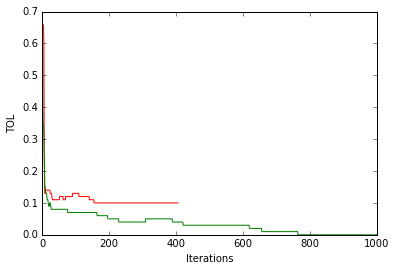


For Gaussian activation funciton
Training data:
RBF correctly identified 90 out of 100 points
This gives an accuracy of 90.0% 
Test data:
RBF correctly identified 47 out of 50 points
This gives an accuracy of 94.0% 

For the Ricker Wavelet activation function
Training data:
RBF correctly identified 100 out of 100 points
This gives an accuracy of 100.0% 
Test data:
RBF correctly identified 48 out of 50 points
This gives an accuracy of 96.0% 


In [13]:
completeRBFNet(irisInput, irisTarget, 15 , 0.0005, 1000)